In [2]:
!pip install seaborn

In [13]:
# -*- coding: utf-8 -*-
"""
Pre-analysis visualization for Phase-1 PK/PD dataset
Produces a figure pack under ./figs_pre

Input: EstData.csv with columns:
ID, BW, COMED, DOSE, TIME, DV, EVID, MDV, AMT, CMT, DVID
PK: DVID==1, DV in mg/L
PD: DVID==2, DV in ng/mL
"""

import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from matplotlib import cycler
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140

# ----------------------- brand palette -----------------------
BLUE   = "#0000CD"   # base blue
GREEN  = "#76B900"   # NVIDIA green
ORANGE = "#FB8C00"   # Google orange

PALETTE = [BLUE, GREEN, ORANGE]
sns.set_theme(style="whitegrid", context="notebook", palette=PALETTE)
plt.rcParams["axes.prop_cycle"] = cycler(color=PALETTE)

# custom green colormap (white -> GREEN) for intensity maps if needed
NV_GREEN_CMAP = LinearSegmentedColormap.from_list("nv_green", ["#FFFFFF", GREEN], N=256)

# ----------------------- config -----------------------
IN_CSV           = "EstData.csv"
FIG_DIR          = "figs_pre"
THRESHOLD_PD     = 3.3     # ng/mL
DEFAULT_INTERVAL = 24.0    # h
os.makedirs(FIG_DIR, exist_ok=True)

# ----------------------- load -------------------------
df = pd.read_csv(IN_CSV)
# coerce numerics (soft)
num_cols = ["ID","BW","COMED","DOSE","TIME","DV","EVID","MDV","AMT","CMT","DVID"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# keep only essential rows well-formed (do not drop extra columns)
df = df.dropna(subset=["ID","TIME","EVID","MDV","DVID"]).copy()
df = df[df["TIME"] >= 0].copy()
df = df.sort_values(["ID","TIME"]).reset_index(drop=True)

print(f"Loaded {IN_CSV}: shape={df.shape}")
print("Columns:", list(df.columns))

# convenience slices
is_obs = (df["EVID"]==0) & (df["MDV"]==0)
obs    = df[is_obs].copy()
pk     = obs[obs["DVID"]==1].copy()
pd_df  = obs[obs["DVID"]==2].copy()
doses  = df[df["EVID"]==1].copy()

# ---------------- distributions -----------------------
def hist(col, data, bins=30, title=None, outpng="hist.png"):
    if col not in data.columns: return
    s = data[col].dropna()
    if s.empty: return
    plt.figure(figsize=(6,4))
    sns.histplot(s, bins=bins, kde=False, color=BLUE)
    plt.xlabel(col); plt.ylabel("count")
    if title: plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

hist("BW", df, title="Body weight distribution (kg)", outpng="hist_BW.png")
hist("DOSE", doses, title="Dosing amount distribution (AMT/DOSE)", outpng="hist_dose_amounts.png")
hist("TIME", obs, title="Sampling time distribution (h, all obs)", outpng="hist_sampling_times.png")

# ---------------- helpers for schedule/relative time ---------------
def infer_tau_for_subject(dose_times, default_tau=24.0):
    tt = np.sort(np.array(dose_times, float))
    if len(tt) >= 2:
        return float(np.median(np.diff(tt)))
    return float(default_tau)

def first_anchor_time_for_subject(s):
    """Prefer first dose time; else first observation time."""
    s = s.sort_values("TIME")
    fd = s[s["EVID"]==1]["TIME"].dropna()
    if len(fd): return float(fd.min())
    fo = s[(s["EVID"]==0)&(s["MDV"]==0)]["TIME"].dropna()
    return float(fo.min()) if len(fo) else np.nan

# ---------------- REVISED dosing visualization ----------------
def plot_dosing_raster_relative(doses_df, df_all, outpng="dosing_raster_relative.png"):
    """
    Clear picture of when each subject was dosed: each dot is a dose event,
    x = hours since subject's start (first dose if available), y = subject ID.
    """
    if doses_df.empty: return
    rows = []
    for sid, s in df_all.groupby("ID"):
        d = s[s["EVID"]==1].copy()
        if d.empty: 
            continue
        t0 = first_anchor_time_for_subject(s)
        if not np.isfinite(t0):
            continue
        d = d.sort_values("TIME")
        d["t_rel_h"] = d["TIME"] - t0
        d["ID"] = int(sid)
        d["dose_idx"] = np.arange(1, len(d)+1)
        rows.append(d[["ID","t_rel_h","dose_idx"]])
    if not rows: return
    jj = pd.concat(rows, ignore_index=True)
    plt.figure(figsize=(10, min(12, 0.22*jj["ID"].nunique()+2)))
    # scatter: relative time on x, subject on y
    plt.scatter(jj["t_rel_h"], jj["ID"], s=10, color=GREEN, alpha=0.9)
    plt.xlabel("Relative time since subject start (h)")
    plt.ylabel("Subject ID")
    plt.title("Dosing raster by subject (each dot = a dose event)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

plot_dosing_raster_relative(doses, df)

# ---------------- PK spaghetti + median/IQR ------------
def time_median_iqr(df_in, tcol="TIME", ycol="DV", nbins=20):
    if df_in.empty: 
        return None
    t = df_in[tcol].values
    y = df_in[ycol].values
    if len(t)==0: return None
    bins = np.linspace(np.nanmin(t), np.nanmax(t), nbins+1)
    mids, med, q25, q75 = [], [], [], []
    for i in range(nbins):
        m = (t >= bins[i]) & (t < bins[i+1])
        if np.sum(m) >= 3:
            mids.append(0.5*(bins[i]+bins[i+1]))
            vals = y[m]
            med.append(np.nanmedian(vals))
            q25.append(np.nanpercentile(vals, 25))
            q75.append(np.nanpercentile(vals, 75))
    if not mids: 
        return None
    return pd.DataFrame({"t":mids, "med":med, "q25":q25, "q75":q75})

def plot_pk_spaghetti(pk, outpng="pk_spaghetti.png"):
    if pk.empty: return
    plt.figure(figsize=(8,5))
    for sid, s in pk.groupby("ID"):
        plt.plot(s["TIME"], s["DV"], lw=0.8, alpha=0.4)
    sm = time_median_iqr(pk[["TIME","DV"]].dropna(), nbins=24)
    if sm is not None:
        plt.plot(sm["t"], sm["med"], color="k", lw=2, label="Median")
        plt.fill_between(sm["t"], sm["q25"], sm["q75"], color="k", alpha=0.15, label="IQR")
    plt.xlabel("Time since start (h)")
    plt.ylabel("Concentration (mg/L)  [PK DVID=1]")
    plt.title("PK spaghetti (all subjects) with median/IQR")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

plot_pk_spaghetti(pk)

# Dose vs Cmax (per subject)
def pk_subject_summaries(pk):
    rows=[]
    for sid, s in pk.groupby("ID"):
        cmax = float(s["DV"].max()) if not s.empty else np.nan
        tmax = float(s.loc[s["DV"].idxmax(),"TIME"]) if not s.empty else np.nan
        rows.append({"ID":int(sid), "Cmax":cmax, "Tmax":tmax})
    return pd.DataFrame(rows)

def plot_dose_vs_cmax(pk, df_all, outpng="pk_dose_vs_cmax.png"):
    if pk.empty: return
    summ = pk_subject_summaries(pk)
    drows = []
    for sid, s in df_all.groupby("ID"):
        d = s[s["EVID"]==1]
        if d.empty:
            dose = float(s["DOSE"].replace(0,np.nan).median())
        else:
            dose = float(d["AMT"].median()) if d["AMT"].notna().any() else float(s["DOSE"].replace(0,np.nan).median())
        drows.append({"ID":int(sid), "Dose_mg":dose})
    dt = pd.DataFrame(drows)
    j = summ.merge(dt, on="ID", how="left").dropna(subset=["Dose_mg","Cmax"])
    if j.empty: return
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=j, x="Dose_mg", y="Cmax", color=BLUE)
    sns.regplot(data=j, x="Dose_mg", y="Cmax", scatter=False, ci=None, color="k", line_kws={"lw":1})
    plt.xlabel("Dose (mg)"); plt.ylabel("Cmax (mg/L)")
    plt.title("PK: Dose vs Cmax (per subject)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

plot_dose_vs_cmax(pk, df)

# ---------------- PD over time + threshold --------------
def plot_pd_spaghetti(pd_df, outpng="pd_spaghetti.png"):
    if pd_df.empty: return
    plt.figure(figsize=(8,5))
    for sid, s in pd_df.groupby("ID"):
        plt.plot(s["TIME"], s["DV"], lw=0.8, alpha=0.4)
    sm = time_median_iqr(pd_df[["TIME","DV"]].dropna(), nbins=24)
    if sm is not None:
        plt.plot(sm["t"], sm["med"], color="k", lw=2, label="Median")
        plt.fill_between(sm["t"], sm["q25"], sm["q75"], color="k", alpha=0.15, label="IQR")
    plt.axhline(THRESHOLD_PD, color="tab:red", ls="--", lw=1.2, label=f"Threshold {THRESHOLD_PD} ng/mL")
    plt.xlabel("Time since start (h)")
    plt.ylabel("Biomarker (ng/mL)  [PD DVID=2]")
    plt.title("PD spaghetti (all subjects) with median/IQR & threshold")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

plot_pd_spaghetti(pd_df)

# PD last-window max distribution (per subject)
def last_window(sdf, interval_h=DEFAULT_INTERVAL, min_points=3, max_expand=8.0):
    if sdf.empty: return sdf.iloc[0:0].copy()
    tmax = float(sdf["TIME"].max()); best, bestn = sdf.iloc[0:0].copy(), 0; f=1.0
    s = sdf.sort_values("TIME")
    while f <= max_expand:
        w = s[(s["TIME"]>=tmax-interval_h*f) & (s["TIME"]<=tmax)]
        if len(w) > bestn:
            best, bestn = w.copy(), len(w)
        if len(w) >= min_points:
            return w
        f *= 1.5
    return best

def pd_last_max_hist(pd_df, df_all, outpng="pd_last_max_hist.png"):
    if pd_df.empty: return
    rows=[]
    for sid, s in pd_df.groupby("ID"):
        ss = df_all[df_all["ID"]==sid]
        d = ss[ss["EVID"]==1]
        if d.empty:
            tau = DEFAULT_INTERVAL
        else:
            tt = np.sort(d["TIME"].dropna().unique())
            tau = float(np.median(np.diff(tt))) if len(tt)>=2 else DEFAULT_INTERVAL
        w = last_window(s, tau, 3, 8.0)
        if w.empty: continue
        rows.append(float(w["DV"].max()))
    if not rows: return
    arr = np.array(rows, float)
    plt.figure(figsize=(6,4))
    sns.histplot(arr, bins=20, kde=False, color=ORANGE)
    plt.axvline(THRESHOLD_PD, color="tab:red", ls="--", lw=1.2, label=f"{THRESHOLD_PD} ng/mL")
    plt.xlabel("PD last-window max (ng/mL)")
    plt.ylabel("count")
    plt.title("Distribution of subject PD_LAST_MAX")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

pd_last_max_hist(pd_df, df)

# ---------------- COMED effect on PD -------------------
def comed_effect(pd_df, df_all, outpng="pd_comed_effect.png"):
    if pd_df.empty: return
    rows=[]
    for sid, s in pd_df.groupby("ID"):
        ss = df_all[df_all["ID"]==sid]
        com = int(ss["COMED"].dropna().iloc[0]) if ss["COMED"].notna().any() else 0
        d = ss[ss["EVID"]==1]
        if d.empty:
            tau = DEFAULT_INTERVAL
        else:
            tt = np.sort(d["TIME"].dropna().unique())
            tau = float(np.median(np.diff(tt))) if len(tt)>=2 else DEFAULT_INTERVAL
        w = last_window(s, tau, 3, 8.0)
        if w.empty: continue
        rows.append({"COMED":com, "PD_LAST_MAX":float(w["DV"].max())})
    jj = pd.DataFrame(rows)
    if jj.empty: return
    plt.figure(figsize=(5.5,4))
    sns.violinplot(data=jj, x="COMED", y="PD_LAST_MAX", inner="quartile", cut=0)
    sns.stripplot(data=jj, x="COMED", y="PD_LAST_MAX", color="0.25", alpha=0.5)
    plt.axhline(THRESHOLD_PD, color="tab:red", ls="--", lw=1.0)
    plt.xlabel("Concomitant medication (0=no, 1=yes)")
    plt.ylabel("PD_LAST_MAX (ng/mL)")
    plt.title("Effect of COMED on PD_LAST_MAX (per subject)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

comed_effect(pd_df, df)

# --------- sampling design diagnostics (REVISED) ----------
def sampling_per_subject(obs, outpng="obs_per_subject.png"):
    cnt = obs.groupby("ID").size()
    plt.figure(figsize=(6,4))
    sns.histplot(cnt, bins=20, color=BLUE)
    plt.xlabel("# observation rows per subject")
    plt.ylabel("count of subjects")
    plt.title("Sampling intensity per subject (all obs)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()
sampling_per_subject(obs)

def sampling_time_density_relative(obs_df, df_all, outpng="sampling_time_density_relative.png"):
    """
    Replaces the old 'sampling_time_heatmap':
    Counts observations in 6 h bins vs relative time since each subject start.
    """
    if obs_df.empty: return
    rows = []
    for sid, s in df_all.groupby("ID"):
        t0 = first_anchor_time_for_subject(s)
        if not np.isfinite(t0): 
            continue
        o = obs_df[obs_df["ID"]==sid].copy()
        if o.empty: 
            continue
        o["t_rel"] = o["TIME"] - t0
        o = o[o["t_rel"] >= 0]
        rows.append(o[["t_rel"]])
    if not rows: return
    jj = pd.concat(rows, ignore_index=True)
    # 6-hour bins
    jj["tbin"] = (np.floor(jj["t_rel"] / 6.0) * 6.0).astype(float)
    ct = jj.groupby("tbin").size().reset_index(name="n")
    plt.figure(figsize=(10,3.2))
    plt.bar(ct["tbin"], ct["n"], width=6.0, align="edge", color=BLUE, edgecolor="none")
    plt.xlabel("Relative time since subject start (h)")
    plt.ylabel("n obs per 6 h bin")
    plt.title("Observation density over relative time (6 h bins)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

sampling_time_density_relative(obs, df)

# --------- more-informative sampling diagnostics ----------
def add_time_since_last_dose_for_obs(df_all, obs_df, default_tau=24.0):
    rows = []
    for sid, s in obs_df.groupby("ID"):
        ss = df_all[df_all["ID"]==sid].sort_values("TIME")
        d  = ss[ss["EVID"]==1]["TIME"].dropna().values
        tau = infer_tau_for_subject(d, default_tau)
        ot = ss[(ss["EVID"]==0) & (ss["MDV"]==0)][["TIME","DVID","DV"]].copy()
        ot["ID"] = sid
        if len(d) == 0:
            ot["time_since_dose"] = np.nan
        else:
            idx = np.searchsorted(d, ot["TIME"].values, side="right") - 1
            last = np.where(idx >= 0, d[idx], np.nan)
            ot["time_since_dose"] = ot["TIME"].values - last
        ot["tau"] = tau
        rows.append(ot)
    out = pd.concat(rows, ignore_index=True) if rows else obs_df.iloc[0:0].copy()
    out["frac_of_tau"] = (out["time_since_dose"] / out["tau"]).astype(float)
    out.loc[~np.isfinite(out["frac_of_tau"]), "frac_of_tau"] = np.nan
    out["frac_of_tau"] = out["frac_of_tau"] % 1.0
    return out

def plot_sampling_within_tau(obs_df, df_all, outpng="sampling_within_tau.png"):
    jj = add_time_since_last_dose_for_obs(df_all, obs_df, DEFAULT_INTERVAL)
    x = jj["frac_of_tau"].dropna()
    if x.empty: return
    plt.figure(figsize=(6.5,4))
    bins = np.linspace(0, 1, 25)
    sns.histplot(x, bins=bins, kde=False, color=BLUE)
    plt.xlabel("Fraction of dosing interval (0 = just after dose, 1 = just before next)")
    plt.ylabel("n obs")
    plt.title("Where within τ are samples taken?")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

def plot_isi_hist(obs_df, outpng="sampling_isi_hist.png"):
    rows = []
    for sid, s in obs_df.groupby("ID"):
        t = np.sort(s["TIME"].dropna().values)
        if len(t) >= 2:
            dt = np.diff(t)
            rows.append(pd.Series(dt))
    if not rows: return
    isi = pd.concat(rows, ignore_index=True)
    plt.figure(figsize=(6.5,4))
    sns.histplot(isi, bins=30, kde=False, color=ORANGE)
    plt.xlabel("Inter-sample interval (h)")
    plt.ylabel("count")
    plt.title("Distribution of inter-sample intervals across subjects")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

def plot_relative_time_raster(obs_df, df_all, outpng="sampling_relative_time_raster.png"):
    rows = []
    for sid, s in df_all.groupby("ID"):
        s = s.sort_values("TIME")
        t0 = first_anchor_time_for_subject(s)
        if not np.isfinite(t0): 
            continue
        o = obs_df[obs_df["ID"]==sid].copy()
        if o.empty: 
            continue
        o["t_rel"] = o["TIME"] - t0
        o = o[o["t_rel"] >= 0]
        o = o[["ID","t_rel"]]
        rows.append(o)
    if not rows: return
    jj = pd.concat(rows, ignore_index=True)
    plt.figure(figsize=(10, min(12, 0.22*jj["ID"].nunique()+2)))
    plt.scatter(jj["t_rel"], jj["ID"], s=8, color=BLUE, alpha=0.9)
    plt.xlabel("Relative time since subject start (h)")
    plt.ylabel("Subject ID")
    plt.title("Sampling raster by subject (each dot = an observation)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

# make the new plots
plot_sampling_within_tau(obs, df)
plot_isi_hist(obs)
plot_relative_time_raster(obs, df)

# --------- quick PK–PD snapshot (same window) ----------
def pkpd_snapshot(pk, pd_df, df_all, outpng="pkpd_snapshot_cavg_vs_pdmax.png"):
    if pk.empty or pd_df.empty: return
    rows=[]
    for sid in sorted(set(df_all["ID"].unique())):
        pk_s = pk[pk["ID"]==sid]
        pd_s = pd_df[pd_df["ID"]==sid]
        if pk_s.empty or pd_s.empty: continue
        ss = df_all[df_all["ID"]==sid]
        d = ss[ss["EVID"]==1]
        if d.empty:
            tau = DEFAULT_INTERVAL
        else:
            tt = np.sort(d["TIME"].dropna().unique())
            tau = float(np.median(np.diff(tt))) if len(tt)>=2 else DEFAULT_INTERVAL
        wpk = last_window(pk_s, tau, 3, 8.0)
        wpd = last_window(pd_s, tau, 3, 8.0)
        if wpk.empty or wpd.empty: continue
        t = wpk["TIME"].values; c = wpk["DV"].values
        t0 = t - t[0]
        if len(t0)>=2 and (t0[-1] > 0):
            cavg = float(np.trapz(c, t0) / (t0[-1]-t0[0]))
        else:
            cavg = float(np.nanmean(c))
        pdmax = float(wpd["DV"].max())  # ng/mL
        rows.append({"ID":int(sid), "PK_Cavg_window_mg_L":cavg, "PD_last_max_ng_mL":pdmax})
    jj = pd.DataFrame(rows).dropna()
    if jj.empty: return
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=jj, x="PK_Cavg_window_mg_L", y="PD_last_max_ng_mL", color=GREEN)
    plt.axhline(THRESHOLD_PD, color="tab:red", ls="--", lw=1.0)
    plt.xlabel("PK Cavg over last window (mg/L)")
    plt.ylabel("PD last-window max (ng/mL)")
    plt.title("PK–PD snapshot: exposure vs biomarker (per subject)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, outpng), dpi=180)
    plt.close()

pkpd_snapshot(pk, pd_df, df)

# ----------------------- done --------------------------
print(f"\n✅ Figure pack saved to: {os.path.abspath(FIG_DIR)}")
print("Files:")
for f in sorted(os.listdir(FIG_DIR)):
    if f.endswith(".png"):
        print(" -", f)


Loaded EstData.csv: shape=(2820, 11)
Columns: ['ID', 'BW', 'COMED', 'DOSE', 'TIME', 'DV', 'EVID', 'MDV', 'AMT', 'CMT', 'DVID']

✅ Figure pack saved to: /home/jovyan/2025_Quantum_Innovation_Challenge/figs_pre
Files:
 - dosing_raster_relative.png
 - hist_BW.png
 - hist_dose_amounts.png
 - hist_sampling_times.png
 - obs_per_subject.png
 - pd_comed_effect.png
 - pd_last_max_hist.png
 - pd_spaghetti.png
 - pk_dose_vs_cmax.png
 - pk_spaghetti.png
 - pkpd_snapshot_cavg_vs_pdmax.png
 - sampling_isi_hist.png
 - sampling_relative_time_raster.png
 - sampling_time_density_relative.png
 - sampling_within_tau.png


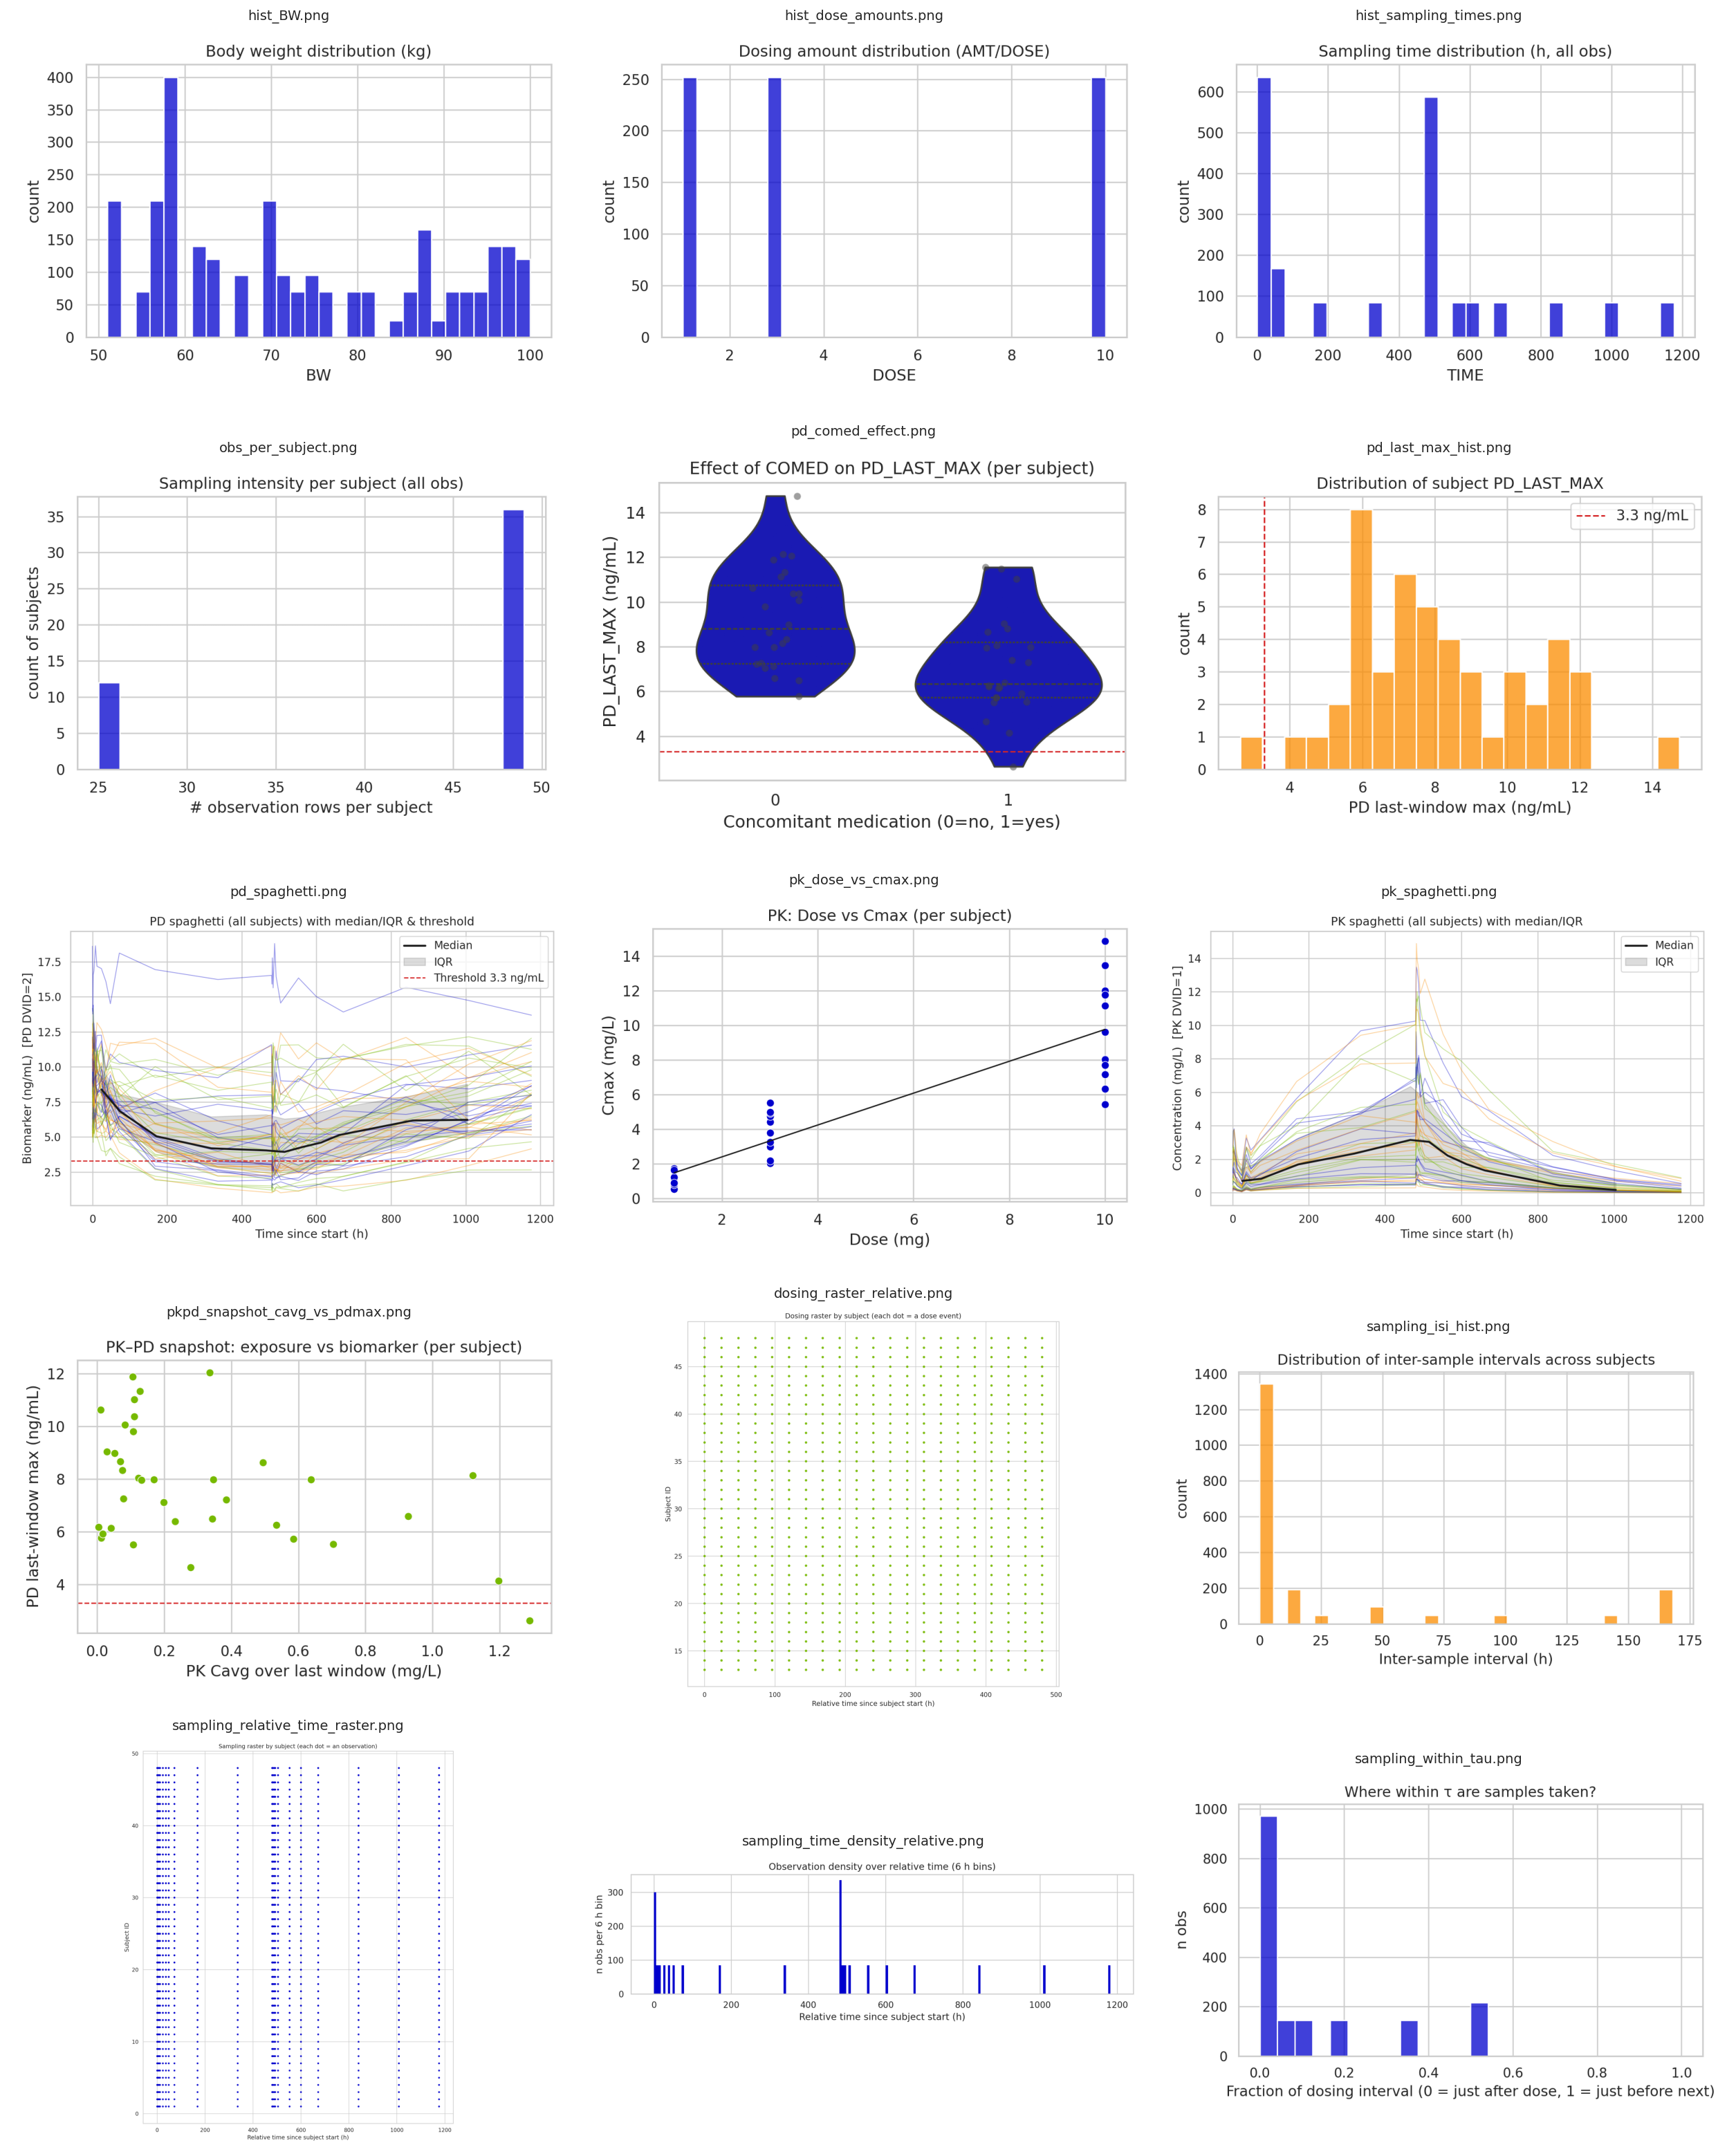

In [14]:
from pathlib import Path
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# folder with the generated figures
FIG_DIR = Path("/home/jovyan/2025_Quantum_Innovation_Challenge/figs_pre")

# desired display order (from your log)
preferred_order = [
    "heatmap_dosing.png",
    "hist_BW.png",
    "hist_dose_amounts.png",
    "hist_sampling_times.png",
    "obs_per_subject.png",
    "pd_comed_effect.png",
    "pd_last_max_hist.png",
    "pd_spaghetti.png",
    "pk_dose_vs_cmax.png",
    "pk_spaghetti.png",
    "pkpd_snapshot_cavg_vs_pdmax.png",
    "sampling_time_heatmap.png",
]

# build the list of files to show (keep preferred order, then any extras)
files = [FIG_DIR / f for f in preferred_order if (FIG_DIR / f).exists()]
extras = [p for p in sorted(FIG_DIR.glob("*.png")) if p.name not in preferred_order]
files.extend(extras)

if not files:
    raise FileNotFoundError(f"No PNGs found in: {FIG_DIR}")

# plot in a grid
n = len(files)
ncols = 3
nrows = math.ceil(n / ncols)
plt.figure(figsize=(ncols * 6, nrows * 4.5))

for i, p in enumerate(files, 1):
    ax = plt.subplot(nrows, ncols, i)
    ax.imshow(mpimg.imread(p))
    ax.set_title(p.name, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()
